In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn xgboost

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar dados
df = pd.read_csv("UCI_Credit_Card.csv")

# Remover a coluna 'ID'
df.drop('ID', axis=1, inplace=True)

# Verificar valores ausentes
print(df.isnull().sum())  # Não há valores ausentes

# Separar features e target
X = df.drop('default.payment.next.month', axis=1)
y = df['default.payment.next.month']

# Escalar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64


In [3]:
# Parâmetros para tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1]
}

# Inicializar modelo
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search
grid = GridSearchCV(xgb, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# Melhor modelo
best_model = grid.best_estimator_
print("Melhores hiperparâmetros:", grid.best_params_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:40:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Melhores hiperparâmetros: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}


AUC: 0.7773691028533619

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.83      0.95      0.89      4673
           1       0.68      0.33      0.45      1327

    accuracy                           0.82      6000
   macro avg       0.76      0.64      0.67      6000
weighted avg       0.80      0.82      0.79      6000


Matriz de Confusão:
 [[4462  211]
 [ 885  442]]


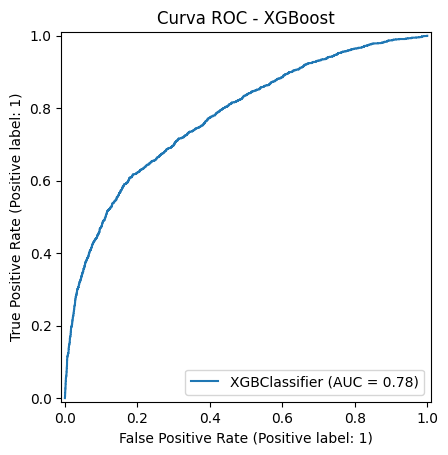

In [4]:
# Prever e avaliar no conjunto de teste
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Métricas
print("AUC:", roc_auc_score(y_test, y_proba))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred))

# Curva ROC
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Curva ROC - XGBoost")
plt.show()


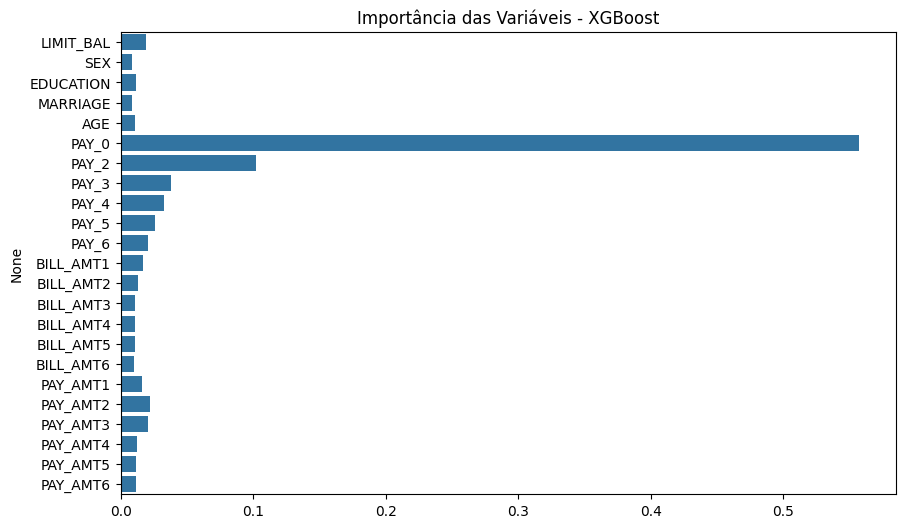

In [5]:
# Importância das features
importances = best_model.feature_importances_
features = df.drop('default.payment.next.month', axis=1).columns

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Importância das Variáveis - XGBoost")
plt.show()
